In [1]:
# %% Imports
import numpy as np
import librosa
import matplotlib.pyplot as plt

import model.signal_to_spectrogram as signal_to_spectrogram

import model.data_manipulation
import model.autosimilarity_computation
import model.barwise_input

In [2]:
import nn_fac.multilayer_nmf as mlnmf
import nn_fac.deep_nmf as dnmf
import matplotlib.pyplot as plt

from nn_fac.utils.current_plot import plot_me_this_spectrogram, plot_spec_with_annotations

In [3]:
# %% Audio params
sr = 44100
feature = "nn_log_mel"

In [4]:
# %% General params
eps = 1e-12
plotting = False # If you want data to be plotted

# %% Deep NMF params
all_ranks = [32,8]
n_iter = 700
n_iter_deep = n_iter - 200 # 100 iterations for the initialization using multi-layer NMF

# %% Audio path
audio_path = 'data/Come_Together.wav'
annotations_path = 'data/Come_Together.lab'

# %% Load audio
signal, _ = librosa.load(audio_path, sr=sr, mono=True)

In [5]:
# %% Application to structure estimation
## Process the data, to compute a barwise TF matrix
bars = model.data_manipulation.get_bars_from_audio(audio_path) # Computing the

oversampled_spectrogram = spectrogram = signal_to_spectrogram.get_spectrogram(signal, sr, hop_length=32, feature=feature)
barwise_tf_matrix = model.barwise_input.barwise_TF_matrix(oversampled_spectrogram, bars, 32/sr, subdivision=96) + eps

## Load the annotations
annotations = model.data_manipulation.get_segmentation_from_txt(annotations_path, "MIREX10")
barwise_annotations = model.data_manipulation.segments_from_time_to_bar(annotations, bars)

/opt/anaconda3/lib/python3.11/site-packages/madmom/io/audio.py:643: WavFileWarning: Chunk (non-data) not understood, skipping it.
  file_sample_rate, signal = wavfile.read(filename, mmap=True)


----------- MultiLayer NMF running ------------
----------- MultiLayer NMF done ------------
Multi-layer NMF on the Barwise TF Matrix: errors (in beta divergence, layer-wise): [[ 294697.5201691   258385.51063546  234397.43206119 ...   99142.03347386
    99136.30181164   99130.68511847]
 [1075019.73917787  971455.44836444  940998.89969362 ...  855702.1896927
   855702.18928817  855702.18888519]], total time of computation: 7273.272261381149.


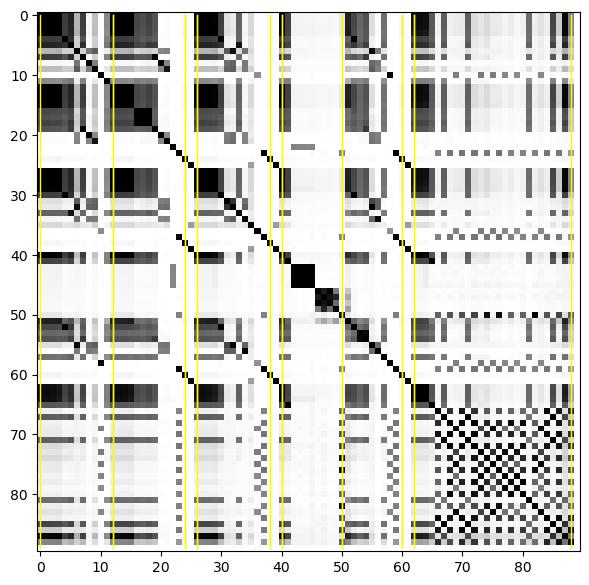

In [15]:
## Apply Multi to the barwise TF matrix
W_multi, H_multi, errors_multi, toc_multi = mlnmf.multilayer_beta_NMF(barwise_tf_matrix, all_ranks = all_ranks, beta = 1, n_iter_max_each_nmf = n_iter, return_errors = True)
print(f"Multi-layer NMF on the Barwise TF Matrix: errors (in beta divergence, layer-wise): {errors_multi}, total time of computation: {np.sum(toc_multi)}.")
as_multi = model.autosimilarity_computation.get_cosine_autosimilarity(W_multi)
plot_spec_with_annotations(as_multi, barwise_annotations)

In [16]:
# Check the constraints on H_l
l = 0
print("Layer 1:", np.sum(H_multi[l], axis=1))
l = 1
print("Layer 2:", np.sum(H_multi[l], axis=1))

Layer 1: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1.]
Layer 2: [1. 1. 1. 1. 1. 1. 1. 1.]


----------- Deep NMF running ------------
----------- MultiLayer NMF running ------------
----------- MultiLayer NMF done ------------
----------- Deep NMF done ------------
Deep NMF on the Barwise TF Matrix: errors per itaration (in relative beta-divergence, compared to the init): [[1.09671367e+05 1.06433917e+00 1.09085805e+00 ... 1.16290294e+00
  1.16286848e+00 1.16283292e+00]
 [6.12337654e+05 7.59142732e-01 6.64465076e-01 ... 2.60264064e-01
  2.60272102e-01 2.60280670e-01]], time of computation after the init: 34.38965153694153.


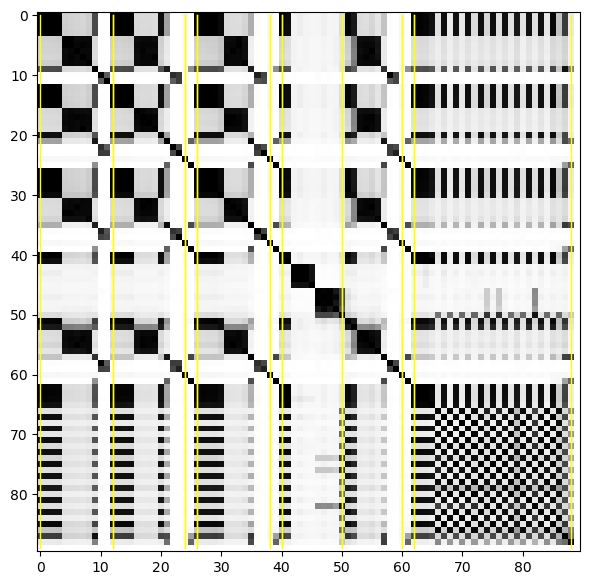

In [17]:
## Apply Deep NMF to the barwise TF matrix
W_deep, H_deep, errors_deep, toc_deep = dnmf.deep_KL_NMF(barwise_tf_matrix, all_ranks = all_ranks, n_iter_max_each_nmf = 200, n_iter_max_deep_loop = n_iter_deep,return_errors=True)
print(f"Deep NMF on the Barwise TF Matrix: errors per itaration (in relative beta-divergence, compared to the init): {errors_deep}, time of computation after the init: {np.sum(toc_deep)}.")
as_deep = model.autosimilarity_computation.get_cosine_autosimilarity(W_deep)
plot_spec_with_annotations(as_deep, barwise_annotations)

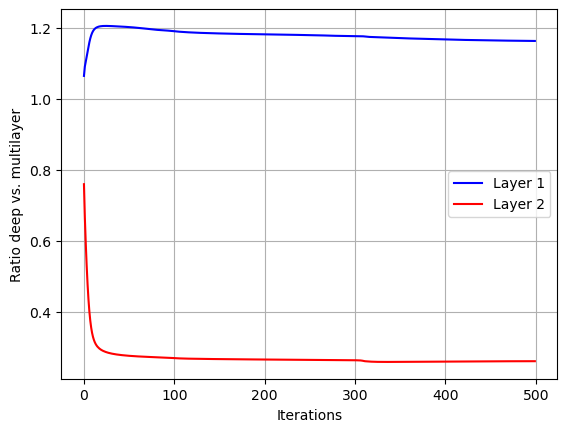

In [18]:
# Evolution of the erros at the different levels of 
# deep β-NMF with β = 1 (initialized with multilayer β-NMF after 250 iterations) 
# divided by the error of multilayer β-NMF after 500 iterations.
plt.figure(1)
plt.plot(errors_deep[0,1:], color='blue', label='Layer 1')
plt.plot(errors_deep[1,1:], color='red', label='Layer 2')
plt.xlabel('Iterations')
plt.ylabel('Ratio deep vs. multilayer')
# plt.title(r'Computation $x^\star$')
plt.legend()
plt.grid()
plt.show()

In [19]:
# Check the constraints on H_l
l = 0
print("Layer 1:", np.sum(H_deep[l], axis=1))
l = 1
print("Layer 2:", np.sum(H_deep[l], axis=1))

Layer 1: [0.99999722 1.00000365 1.00000402 1.00000299 0.99999723 0.99999809
 1.0000037  0.99999778 0.99999924 1.00000289 0.99999542 0.99999952
 0.99999505 0.9999963  0.99999942 0.9999962  1.00000206 1.0000022
 1.00000178 0.99999934 0.99999768 0.99999672 1.00000424 0.99999594
 0.99999746 1.00000264 1.00000392 0.99999571 1.00000062 0.99999824
 1.00000226 1.00000367]
Layer 2: [1. 1. 1. 1. 1. 1. 1. 1.]


We test here-under the multilayer and deep SS NMF

----------- MultiLayer NMF running ------------
Robust multi layer NMF on
iter =    1 | obj = +1.45E+06 | err =  INF (target is 1.00E-05)
iter =   50 | obj = +1.43E+05 | err = 6.46E-03 (target is 1.00E-05)
iter =  100 | obj = +1.24E+05 | err = 1.34E-03 (target is 1.00E-05)
iter =  150 | obj = +1.18E+05 | err = 6.49E-04 (target is 1.00E-05)
iter =  200 | obj = +1.15E+05 | err = 3.70E-04 (target is 1.00E-05)
iter =  250 | obj = +1.13E+05 | err = 2.40E-04 (target is 1.00E-05)
iter =  300 | obj = +1.12E+05 | err = 1.76E-04 (target is 1.00E-05)
iter =  350 | obj = +1.11E+05 | err = 1.32E-04 (target is 1.00E-05)
iter =  400 | obj = +1.11E+05 | err = 1.10E-04 (target is 1.00E-05)
iter =  450 | obj = +1.10E+05 | err = 7.37E-05 (target is 1.00E-05)
iter =  500 | obj = +1.10E+05 | err = 5.99E-05 (target is 1.00E-05)
iter =  550 | obj = +1.09E+05 | err = 6.72E-05 (target is 1.00E-05)
iter =  600 | obj = +1.09E+05 | err = 4.17E-05 (target is 1.00E-05)
iter =  650 | obj = +1.09E+05 | err = 3.70E-05

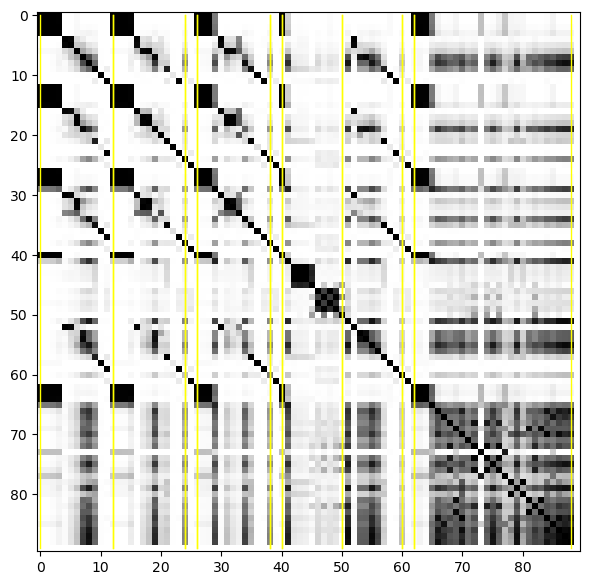

In [6]:
## Apply Multi to the barwise TF matrix
W_multi, H_multi, errors_multi, toc_multi = mlnmf.multilayer_beta_NMF(barwise_tf_matrix, all_ranks = all_ranks, beta = 1, n_iter_max_each_nmf = n_iter, norm_type = "h_cols", return_errors = True)
print(f"Multi-layer NMF on the Barwise TF Matrix: errors (in beta divergence, layer-wise): {errors_multi}, total time of computation: {np.sum(toc_multi)}.")
as_multi = model.autosimilarity_computation.get_cosine_autosimilarity(W_multi)
plot_spec_with_annotations(as_multi, barwise_annotations)

In [12]:
# Check the constraints on H_l
l = 0
print("Layer 1:", np.sum(H_multi[l], axis=0))
l = 1
print("Layer 2:", np.sum(H_multi[l], axis=0))

Layer 1: [1. 1. 1. ... 1. 1. 1.]
Layer 2: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1.]


In [20]:
## Apply Deep NMF to the barwise TF matrix
# Robust deep NMF with SS constraints
# W_deep, H_deep, errors_deep, toc_deep = dnmf.deep_KL_NMF(barwise_tf_matrix, all_ranks = all_ranks, n_iter_max_each_nmf = 100, n_iter_max_deep_loop = n_iter_deep + 100, HnormType = 'cols', robustNMF_on=1, return_errors=True)

# deep NMF with SS constraints - Choose between NR or Bisec Method for computation of Lagrangian multipliers
W_deep, H_deep, errors_deep, toc_deep = dnmf.deep_KL_NMF(barwise_tf_matrix, all_ranks = all_ranks, n_iter_max_each_nmf = 100, n_iter_max_deep_loop = n_iter_deep + 100, HnormType = 'cols', mul_la_Method = 'NR', epsi=1e-8, return_errors=True)

print(f"Deep NMF on the Barwise TF Matrix: errors per itaration (in relative beta-divergence, compared to the init): {errors_deep}, time of computation after the init: {np.sum(toc_deep)}.")
as_deep = model.autosimilarity_computation.get_cosine_autosimilarity(W_deep)
plot_spec_with_annotations(as_deep, barwise_annotations)

----------- Deep NMF running ------------
----------- MultiLayer NMF running ------------
Robust multi layer NMF on
iter =    1 | obj = +1.45E+06 | err =  INF (target is 1.00E-05)
iter =   50 | obj = +1.33E+05 | err = 7.31E-03 (target is 1.00E-05)
iter =  100 | obj = +1.15E+05 | err = 1.08E-03 (target is 1.00E-05)
iter =  150 | obj = +1.11E+05 | err = 5.31E-04 (target is 1.00E-05)
iter =  200 | obj = +1.09E+05 | err = 2.87E-04 (target is 1.00E-05)
Robust multi layer NMF on
iter =    1 | obj = +4.55E+04 | err =  INF (target is 1.00E-05)
iter =   50 | obj = +1.25E+04 | err = 1.03E-04 (target is 1.00E-05)
iter =  100 | obj = +1.25E+04 | err = 1.71E-05 (target is 1.00E-05)
iter =  150 | obj = +1.22E+04 | err = 1.15E-05 (target is 1.00E-05)
----------- MultiLayer NMF done ------------


/Users/apple/Documents/GitHub/Deep_NMF_Audio/nn_fac/deep_nmf.py:61: RuntimeWarning: divide by zero encountered in divide
  lambda_ = 1 / np.array(reconstruction_errors[:,0])
/Users/apple/Documents/GitHub/Deep_NMF_Audio/nn_fac/deep_nmf.py:63: RuntimeWarning: invalid value encountered in matmul
  global_errors.append(lambda_.T @ reconstruction_errors[:,0])
/Users/apple/Documents/GitHub/Deep_NMF_Audio/nn_fac/update_rules/deep_mu.py:170: RuntimeWarning: invalid value encountered in divide
  W = np.maximum(eps, 1/lam * b/(np.real(lambertw(1/lam*b*np.exp(a/lam)))))


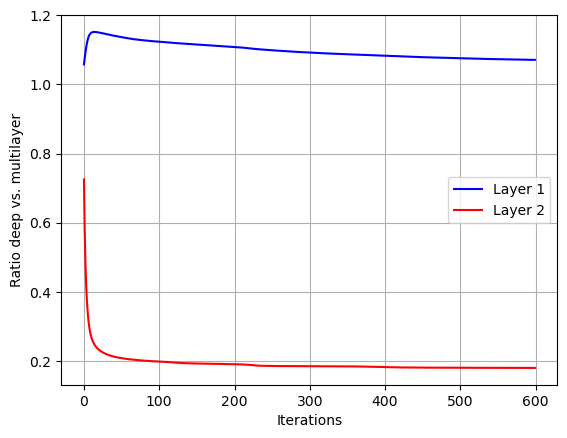

In [12]:
# Evolution of the erros at the different levels of 
# deep β-NMF with β = 1 (initialized with multilayer β-NMF after 100 iterations) 
# divided by the error of multilayer β-NMF after 10 iterations.
plt.figure(1)
plt.plot(errors_deep[0,1:], color='blue', label='Layer 1')
plt.plot(errors_deep[1,1:], color='red', label='Layer 2')
plt.xlabel('Iterations')
plt.ylabel('Ratio deep vs. multilayer')
# plt.title(r'Computation $x^\star$')
plt.legend()
plt.grid()
plt.show()

In [13]:
# Check the constraints on H_l
l = 0
print("Layer 1:", np.sum(H_deep[l], axis=0))
print("Min value - Layer 1:", np.min(np.sum(H_deep[l], axis=0)))
print("Max value - Layer 1:", np.max(np.sum(H_deep[l], axis=0)))
l = 1
print("Layer 2:", np.sum(H_deep[l], axis=0))
print("Min value - Layer 2:", np.min(np.sum(H_deep[l], axis=0)))
print("Max value - Layer 2:", np.max(np.sum(H_deep[l], axis=0)))

Layer 1: [1. 1. 1. ... 1. 1. 1.]
Min value - Layer 1: 0.9999999999999992
Max value - Layer 1: 1.0000000000000038
Layer 2: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1.]
Min value - Layer 2: 0.9999999999999999
Max value - Layer 2: 1.0000000000000007


In [14]:
s = np.sum(H_deep[0], axis=0)
id = np.where(s>1.01)[0]
print(id.size)
print(s[id])

0
[]
